In [1]:
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [2]:
df = pd.read_csv('training.csv')
dftest = pd.read_csv('testing.csv')

In [3]:
target_column_name = 'class'
X = df.drop(target_column_name, axis=1)
y = df[target_column_name]

X_train = df.drop(target_column_name, axis=1)
y_train = df[target_column_name]

X_test = dftest.drop(target_column_name, axis= 1)
y_test = dftest['class']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k=1, CV Mean Accuracy: 0.7431
k=2, CV Mean Accuracy: 0.7729
k=3, CV Mean Accuracy: 0.7679
k=4, CV Mean Accuracy: 0.7622
k=5, CV Mean Accuracy: 0.7918
k=6, CV Mean Accuracy: 0.7742
k=7, CV Mean Accuracy: 0.7742
k=8, CV Mean Accuracy: 0.7679
k=9, CV Mean Accuracy: 0.7918
k=10, CV Mean Accuracy: 0.7738
k=11, CV Mean Accuracy: 0.7799
k=12, CV Mean Accuracy: 0.7677
k=13, CV Mean Accuracy: 0.7619
k=14, CV Mean Accuracy: 0.7558
k=15, CV Mean Accuracy: 0.7383
k=16, CV Mean Accuracy: 0.7439
k=17, CV Mean Accuracy: 0.7501
k=18, CV Mean Accuracy: 0.7378
k=19, CV Mean Accuracy: 0.7201
k=20, CV Mean Accuracy: 0.7082

Best k based on cross-validation: 5 with CV accuracy: 0.7918


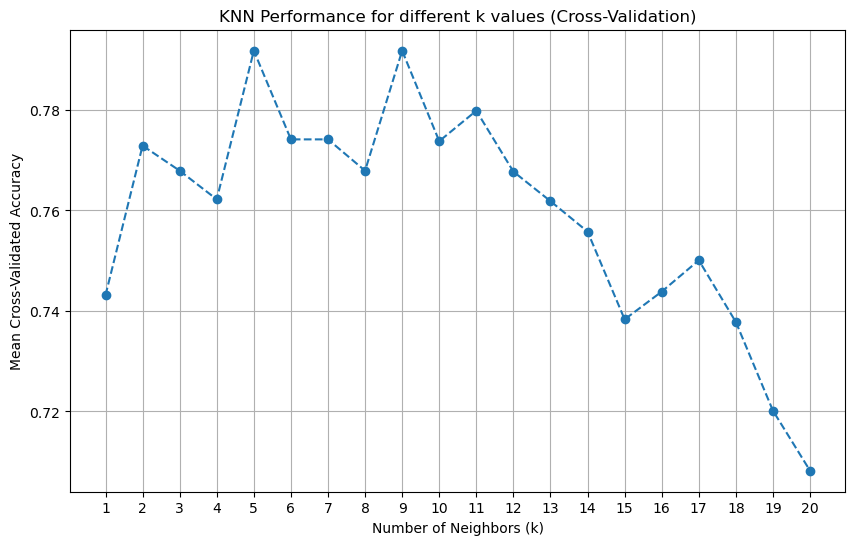

In [4]:
k_range = range(1, 21) # Test k values from 1 to 30 (adjust as needed)
cv_scores = [] # To store cross-validation scores for each k

for k_val in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_val)
    # Perform 5-fold cross-validation (cv=5)
    # 'accuracy' is a common scoring metric. For imbalanced data, consider 'f1_macro', 'f1_weighted', etc.
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f"k={k_val}, CV Mean Accuracy: {scores.mean():.4f}")

best_k_cv = k_range[np.argmax(cv_scores)]
print(f"\nBest k based on cross-validation: {best_k_cv} with CV accuracy: {max(cv_scores):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, marker='o', linestyle='dashed')
plt.title('KNN Performance for different k values (Cross-Validation)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [5]:
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)

knn_model.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Model Accuracy (k={k}): {accuracy:.4f}")

# Optional: Print more detailed evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


KNN Model Accuracy (k=5): 0.7239

Classification Report:
              precision    recall  f1-score   support

    asphalt        0.76      0.71      0.74        45
   building        0.86      0.67      0.75        97
        car        0.94      0.81      0.87        21
   concrete        0.72      0.82      0.76        93
      grass        0.65      0.71      0.68        83
       pool        0.79      0.79      0.79        14
     shadow        0.70      0.69      0.70        45
       soil        0.25      0.35      0.29        20
       tree        0.78      0.78      0.78        89

    accuracy                           0.72       507
   macro avg       0.72      0.70      0.71       507
weighted avg       0.74      0.72      0.73       507



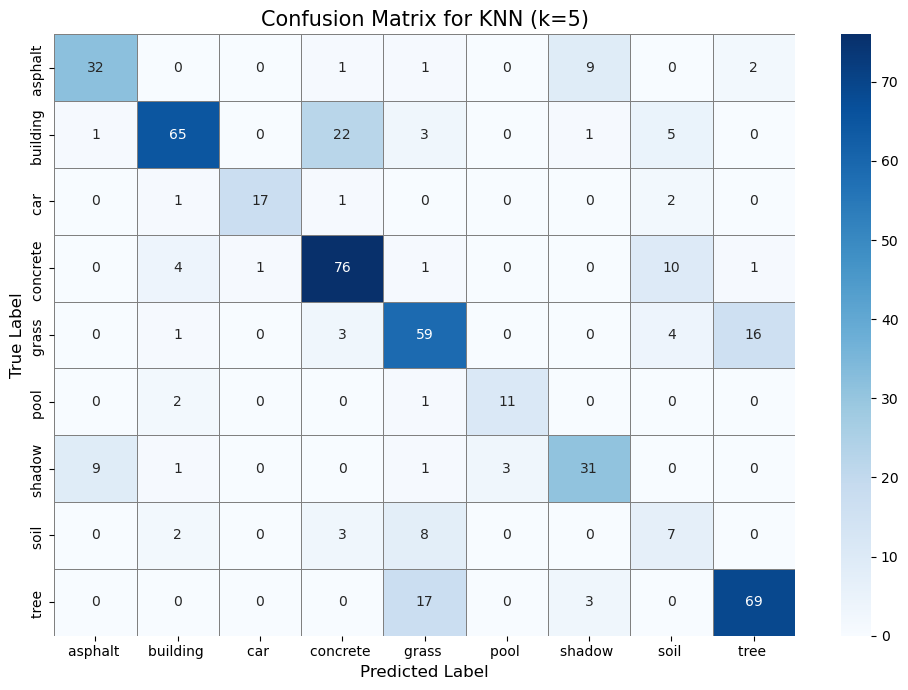

In [6]:
class_labels = np.unique(np.concatenate((y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred, labels=class_labels)

cm_df = pd.DataFrame(cm,
                     index = class_labels,
                     columns = class_labels)

plt.figure(figsize=(10, 7)) # Adjust figure size
sns.heatmap(cm_df,
            annot=True,      # Display the numbers in each cell
            fmt='d',         # Format numbers as integers
            cmap='Blues',    # Colormap
            linewidths=.5,
            linecolor='gray',
            cbar=True)

plt.title(f'Confusion Matrix for KNN (k={best_k_cv})', fontsize=15)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
# plt.xticks(rotation=45, ha='right') # Uncomment if class names are long
# plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [7]:
top_5_feature_names = ['Mean_NIR', 'NDVI', 'NDVI_40', 'Mean_NIR_60', 'NDVI_60']
X_train_top5 = X_train[top_5_feature_names]
X_test_top5 = X_test[top_5_feature_names]

X_train_top5_scaled = scaler.fit_transform(X_train_top5)
X_test_top5_scaled = scaler.fit_transform(X_test_top5)


In [8]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

mlp_for_grid = MLPClassifier(
    random_state=42,
    # Using sklearn defaults for:
    # solver='adam',
    # activation='relu',
    # alpha=0.0001,
    # learning_rate_init=0.001,
    # early_stopping=False (because max_iter is being tuned in the grid)
)

# Define the grid of hyperparameters to search
# For hidden_layer_sizes, (k,) means one layer with k neurons (k <= 25)
k_values_for_grid = [k for k in range(5, 26, 5)] # e.g., [5, 10, 15, 20, 25]
iteration_values_for_grid = [50, 100, 150, 200, 250] # Example iteration values

param_grid_part_b = {
    'hidden_layer_sizes': [(k,) for k in k_values_for_grid],
    'max_iter': iteration_values_for_grid
}

# Setup GridSearchCV
# cv=10 for 10-fold cross-validation
grid_search_b = GridSearchCV(
    estimator=mlp_for_grid,
    param_grid=param_grid_part_b,
    cv=10,
    scoring='accuracy',
    verbose=1, # Set to 0 for less output, 1 or 2 for more
    n_jobs=-1  # Use all available CPU cores
)

print("Starting GridSearchCV to find best k and iterations for Part B(b)...")
# Fit GridSearchCV on the scaled training data (df_X_scaled, df_y)
grid_search_b.fit(X_train_scaled, y_train)

# --- Report Results for Part B(b) ---
print("\n--- Results for Part B(b) ---")
print(f"Best parameters found by GridSearchCV: {grid_search_b.best_params_}")

# Extract the best k and best iterations from the results
best_k_b = grid_search_b.best_params_['hidden_layer_sizes'][0]
best_iterations_b = grid_search_b.best_params_['max_iter']
baseline_cv_accuracy_b = grid_search_b.best_score_

print(f"Optimal number of neurons (k): {best_k_b}")
print(f"Optimal number of iterations: {best_iterations_b}")
print(f"Highest Average 10-fold CV Accuracy (Baseline for Part B): {baseline_cv_accuracy_b:.4f}")


Starting GridSearchCV to find best k and iterations for Part B(b)...
Fitting 10 folds for each of 25 candidates, totalling 250 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_mult


--- Results for Part B(b) ---
Best parameters found by GridSearchCV: {'hidden_layer_sizes': (15,), 'max_iter': 200}
Optimal number of neurons (k): 15
Optimal number of iterations: 200
Highest Average 10-fold CV Accuracy (Baseline for Part B): 0.7555


LabelEncoder classes (mapping): ['asphalt ' 'building ' 'car ' 'concrete ' 'grass ' 'pool ' 'shadow '
 'soil ' 'tree ']

--- Baseline Model Results ---
Number of neurons: 20
Best number of iterations (found by early stopping): 18
Highest validation accuracy during training: 0.4118
Final accuracy on test set: 0.2880


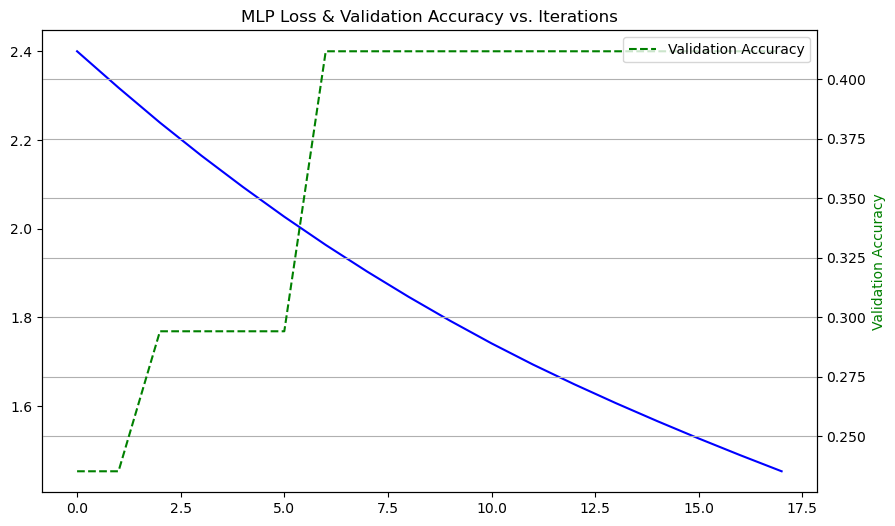

In [9]:
from sklearn.preprocessing import LabelEncoder

# 1. Initialize the encoder
le = LabelEncoder()

# 2. Fit the encoder on the training labels and transform them to integers
y_train_encoded = le.fit_transform(y_train)

# 3. Use the SAME fitted encoder to transform the test labels
y_test_encoded = le.transform(y_test)

# You can see the mapping it learned
print("LabelEncoder classes (mapping):", le.classes_)

neurons_k = 20
mlp = MLPClassifier(
    hidden_layer_sizes=(neurons_k,),
    max_iter=200,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

mlp.fit(X_train_scaled, y_train_encoded)

best_iterations = mlp.n_iter_
best_validation_accuracy = max(mlp.validation_scores_)
final_test_accuracy = mlp.score(X_test_scaled, y_test_encoded)

print("\n--- Baseline Model Results ---")
print(f"Number of neurons: {neurons_k}")
print(f"Best number of iterations (found by early stopping): {best_iterations}")
print(f"Highest validation accuracy during training: {best_validation_accuracy:.4f}")
print(f"Final accuracy on test set: {final_test_accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_, label='Training Loss', color='blue')

ax2 = plt.gca().twinx()
ax2.plot(mlp.validation_scores_, label='Validation Accuracy', color='green', linestyle='--')

plt.title('MLP Loss & Validation Accuracy vs. Iterations')
plt.xlabel('Iteration (Epoch)')
plt.ylabel('Training Loss', color='blue')
ax2.set_ylabel('Validation Accuracy', color='green')
plt.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()